# Árboles de decisión

<div style="text-align: right"><a>por </a><a href="https://www.linkedin.com/in/sheriff-data/" target="_blank">Manuel López Sheriff</a></div>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Intro

Un árbol de decisión intenta predecir la variable objetivo utilizando una lógica como la siguiente:

<img width=600 src="https://miro.medium.com/v2/resize:fit:1084/1*U6twhNSe1I37feFfBaeXLw.png">

Árboles de decisión:
 * se utilizan tanto para la clasificación (ejemplo anterior Fit/Unfit) como para la regresión
 * implican estratificar (segmentar) el espacio de predictores...
 * de forma iterativa
 * reciben este nombre porque las reglas de división pueden resumirse en un árbol

Árboles de decisión:
 * son simples
 * son útiles para la interpretación
 * no son predictores muy potentes, pero...
 * dan lugar a modelos más complejos, como los algoritmos Random Forest o Gradient Boosted Trees

## El problema

Hoy utilizaremos un conjunto de datos de **vino blanco**.

Los expertos han calificado varios vinos, cuyas propiedades físicas también se indican

In [3]:
df = pd.read_csv("./datasets/wine_quality.csv")

In [4]:
df.shape

(4898, 12)

In [5]:
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1028,7.0,0.240,0.35,1.5,0.052,51.0,128.0,0.99410,3.41,0.59,10.4,7
3556,4.8,0.210,0.21,10.2,0.037,17.0,112.0,0.99324,3.66,0.48,12.2,7
747,7.2,0.290,0.40,7.6,0.024,56.0,177.0,0.99280,3.04,0.32,11.5,6
647,7.4,0.105,0.34,12.2,0.050,57.0,146.0,0.99730,3.16,0.37,9.0,6
2901,6.5,0.220,0.32,2.2,0.028,36.0,92.0,0.99076,3.27,0.59,11.9,7


### Exploración de datos

In [6]:
# renombramos las columnas por comodidad
df.columns = [col.replace(" ", "_") for col in df.columns]

In [7]:
df.sample(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1739,8.4,0.29,0.29,1.05,0.032,4.0,55.0,0.99080,2.91,0.32,11.4,4
998,8.0,0.24,0.30,17.45,0.056,43.0,184.0,0.99970,3.05,0.50,9.2,6
3559,7.5,0.34,0.24,3.85,0.031,5.0,34.0,0.99098,3.01,0.36,11.8,4
3180,6.5,0.24,0.38,1.00,0.027,31.0,90.0,0.98926,3.24,0.36,12.3,6
3896,6.7,0.26,0.29,7.70,0.038,40.0,179.0,0.99479,3.23,0.56,10.4,6


Queremos:
 * construir un modelo de aprendizaje **supervisado**
 * de **regresión** (predecir variable cuantitativa)
 * que intenta predecir la `quality` del vino a partir de sus propiedades físicas (de modo que ya no necesitemos el asesoramiento de expertos)

<Axes: xlabel='quality', ylabel='count'>

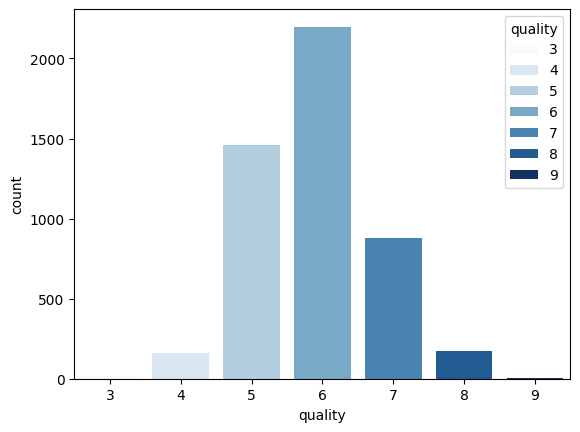

In [18]:
sns.countplot(x=df.quality, hue=df.quality, palette="Blues")

In [10]:
df.quality.value_counts().sort_index()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

In [23]:
df.corr()["quality"].sort_values().round(3)

density                -0.307
chlorides              -0.210
volatile_acidity       -0.195
total_sulfur_dioxide   -0.175
fixed_acidity          -0.114
residual_sugar         -0.098
citric_acid            -0.009
free_sulfur_dioxide     0.008
sulphates               0.054
pH                      0.099
alcohol                 0.436
quality                 1.000
Name: quality, dtype: float64

<Axes: xlabel='alcohol', ylabel='quality'>

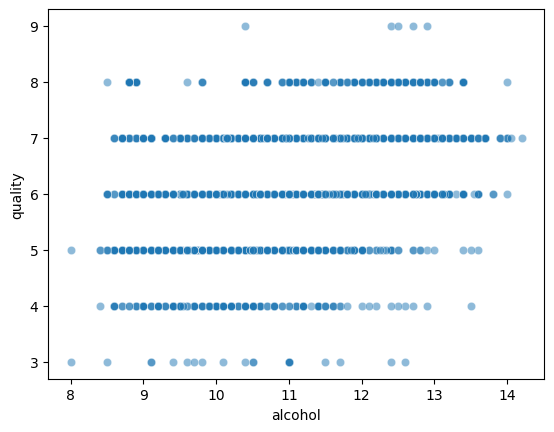

In [32]:
sns.scatterplot(x=df.alcohol, y=df.quality, alpha=0.5)

/tmp/ipykernel_5862/255594615.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df.quality, y=df.alcohol, palette="Blues")


<Axes: xlabel='quality', ylabel='alcohol'>

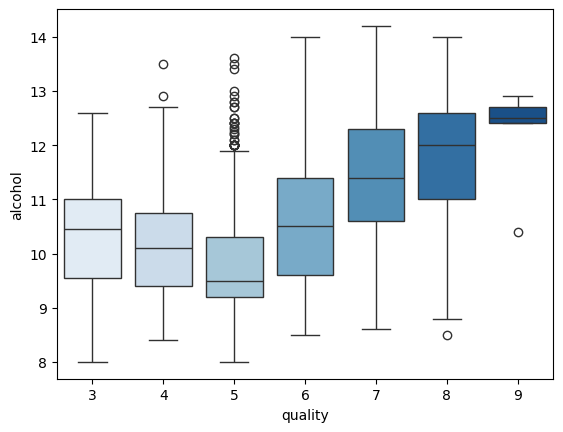

In [33]:
sns.boxplot(x=df.quality, y=df.alcohol, palette="Blues")

In [38]:
df.groupby("quality").alcohol.median().sort_index().round(3)

quality
3    10.45
4    10.10
5     9.50
6    10.50
7    11.40
8    12.00
9    12.50
Name: alcohol, dtype: float64

<Axes: xlabel='fixed_acidity', ylabel='volatile_acidity'>

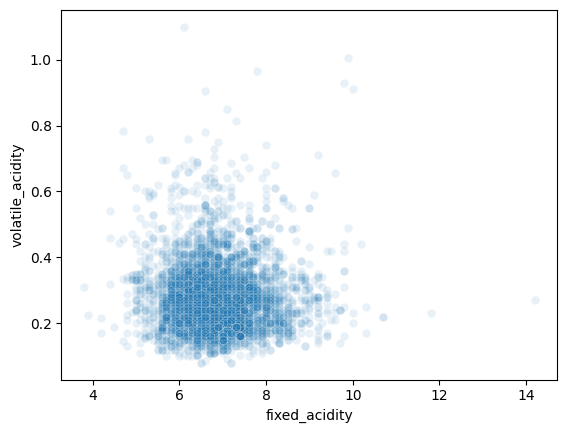

In [39]:
sns.scatterplot(x=df.fixed_acidity, y=df.volatile_acidity, alpha=0.1)

<Axes: xlabel='alcohol', ylabel='Count'>

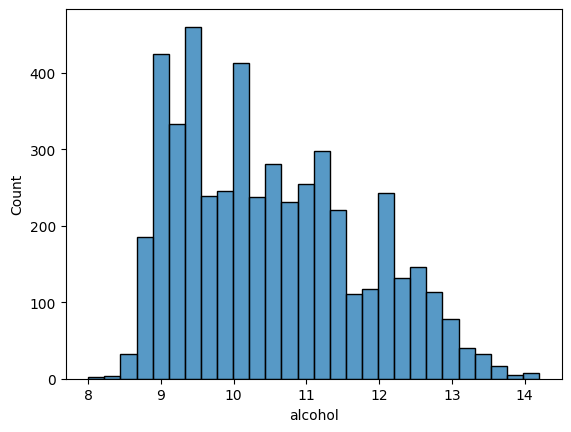

In [40]:
sns.histplot(x=df.alcohol)

### Train / test split

In [41]:
from sklearn.model_selection import train_test_split

In [43]:
X = df.drop("quality", axis=1)

In [44]:
y = df.quality

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98)

In [46]:
X_train.shape

(3918, 11)

In [47]:
X_test.shape

(980, 11)

### Paréntesis: construyamos una regresión lineal

Para evaluar correctamente el rendimiento del modelo, usaremos train/test split y la métrica RMSE

$$RMSE=\sqrt{\frac{1}{N} \sum(y - \hat{y})^2}$$

In [49]:
from sklearn.metrics import root_mean_squared_error

1. Instancio una regresión lineal.

In [51]:
from sklearn.linear_model import LinearRegression

In [52]:
lin = LinearRegression()

2. La entreno con los 3918 vinos de train

In [53]:
lin.fit(
    X=X_train, 
    y=y_train
)

LinearRegression()

3. Cojo un vino nuevo. Cómo se predice su `quality`?

In [55]:
X_test[:5]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
2489,6.1,0.28,0.24,19.95,0.074,32.0,174.0,0.99922,3.19,0.44,9.300000
117,7.0,0.14,0.40,1.70,0.035,16.0,85.0,0.99110,3.19,0.42,11.800000
938,6.2,0.35,0.29,7.30,0.044,56.0,244.0,0.99560,3.36,0.55,10.000000
3630,6.6,0.30,0.25,8.00,0.036,21.0,124.0,0.99362,3.06,0.38,10.800000
4358,6.5,0.23,0.20,7.50,0.050,44.0,179.0,0.99504,3.18,0.48,9.533333


In [56]:
lin.predict(X_test[:5]).round(2)

array([5.91, 6.33, 5.6 , 5.89, 5.74])

In [57]:
y_test[:5]

2489    6
117     6
938     6
3630    6
4358    5
Name: quality, dtype: int64

In [59]:
# test error (MSE)
root_mean_squared_error(y_test, lin.predict(X_test)).round(3)

0.798

In [61]:
# train error (MSE)
root_mean_squared_error(y_train, lin.predict(X_train)).round(3)

0.74

Suele funcionar mejor el modelo sobre el train

## Decision trees

Vamos a:
 * probar varios modelos y...
 * nos quedaremos con el que tenga el **menor** RMSE en el **conjunto de test** (también llamado test error)
 * también mostraremos el error en el train

### Regresión lineal

Recordemos los resultados anteriores de la regresión lineal:

In [61]:
# train error (MSE)
root_mean_squared_error(y_train, lin.predict(X_train)).round(3)

0.74

In [59]:
# test error (MSE)
root_mean_squared_error(y_test, lin.predict(X_test)).round(3)

0.798

### Simple tree (depth=1)

Primero entrenemos el Decision Tree, luego interpretémoslo

In [62]:
from sklearn.tree import DecisionTreeRegressor

In [63]:
model = DecisionTreeRegressor(max_depth=1, random_state=6666)

In [64]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=6666)

Veamos cómo predice este modelo los 5 primeros vinos

In [65]:
# real values
y_test[:5]

2489    6
117     6
938     6
3630    6
4358    5
Name: quality, dtype: int64

In [66]:
# predicted values
model.predict(X_test[:5].values).round(2)

/home/sheriff/.devpy/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([5.6 , 6.37, 5.6 , 5.6 , 5.6 ])

Train error

In [67]:
root_mean_squared_error(
    y_true=y_train,
    y_pred=model.predict(X_train),
).round(3)

0.799

Test error

In [68]:
root_mean_squared_error(
    y_true=y_test,
    y_pred=model.predict(X_test),
).round(3)

0.86

In [69]:
from sklearn.tree import plot_tree

In [70]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [71]:
y_train.mean()

5.8825931597753955

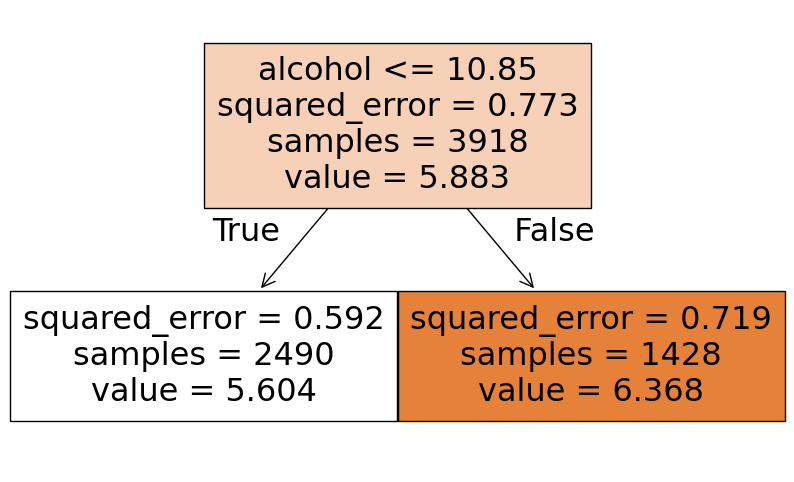

In [72]:
fig = plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=df.columns[:-1], filled=True);

Es la media ponderada de los MSE de las hojas

Algunas preguntas importantes para una comprensión profunda:

 1. durante el entrenamiento, ¿por qué el árbol de decisión eligió la variable `alcohol` y el corte $10.85$?

Veamos qué hace el árbol en detalle para tomar esta decisión:

Imagina que elegimos `residual_sugar` y el valor 5

In [74]:
group1 = X_train[X_train.residual_sugar <= 5].copy()
group2 = X_train[X_train.residual_sugar > 5].copy()

In [75]:
group1.shape

(1914, 11)

In [76]:
group2.shape

(2004, 11)

In [77]:
group1_mean = y_train[group1.index].mean()

In [78]:
group1_mean

5.974921630094044

In [79]:
group2_mean = y_train[group2.index].mean()

In [80]:
group2_mean

5.794411177644711

In [81]:
mse = ((
    ((y_train[group1.index] - group1_mean) ** 2).sum() +
    ((y_train[group2.index] - group2_mean) ** 2).sum()
) / X_train.shape[0])

In [82]:
mse

0.7652102203762468

Mejora pequeña sobre el modelo de referencia, y mucho peor que el alcohol 10.85, que es el par (característica-umbral) óptimo

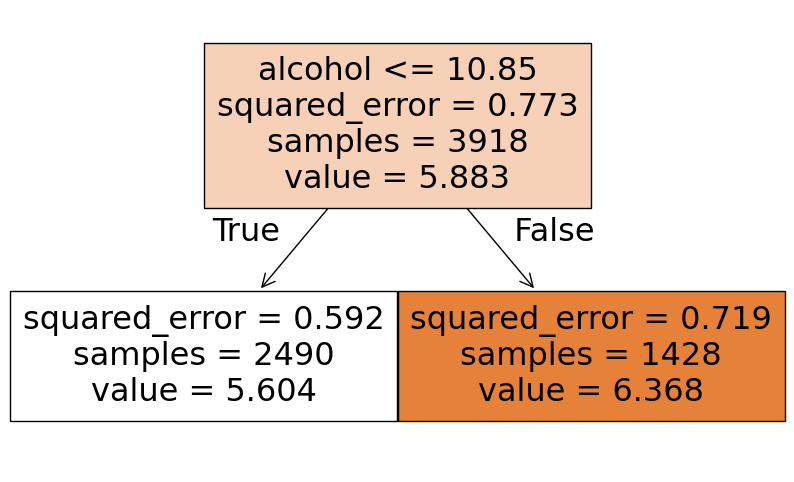

In [84]:
fig = plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=df.columns[:-1], filled=True);

2. qué significa `squared_error`?  
   el error cuadrático medio en esa rama: el que se obtendría si a cada vino de esa rama se le diera la media de la rama

3. qué significa `value`?  
   la calidad media de los vinos de esa rama. El valor que se predecirá para cada nuevo vino que termine en esa hoja del árbol.

4. durante el testing (predicción de una nueva instancia), ¿cómo funciona el árbol?  
   Recorre un único camino. Cuando este camino termina, el valor en esa hoja es la predicción

### Bigger tree (depth=3)

In [85]:
model = DecisionTreeRegressor(max_depth=3, random_state=666)

In [86]:
%%time
model.fit(X_train, y_train)

CPU times: user 15.2 ms, sys: 1.03 ms, total: 16.3 ms
Wall time: 14.5 ms


DecisionTreeRegressor(max_depth=3, random_state=666)

In [88]:
# real values
y_test[:10]

2489    6
117     6
938     6
3630    6
4358    5
3392    6
1655    5
671     6
734     5
1785    6
Name: quality, dtype: int64

In [89]:
# predicted values
model.predict(X_test[:10].values).round(2)

/home/sheriff/.devpy/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([5.55, 6.61, 5.24, 5.55, 5.86, 6.61, 5.55, 6.23, 5.24, 6.23])

Train error

In [90]:
root_mean_squared_error(
    y_true=y_train,
    y_pred=model.predict(X_train)
).round(3)

0.74

Test error

In [91]:
root_mean_squared_error(
    y_true=y_test,
    y_pred=model.predict(X_test)
).round(3)

0.803

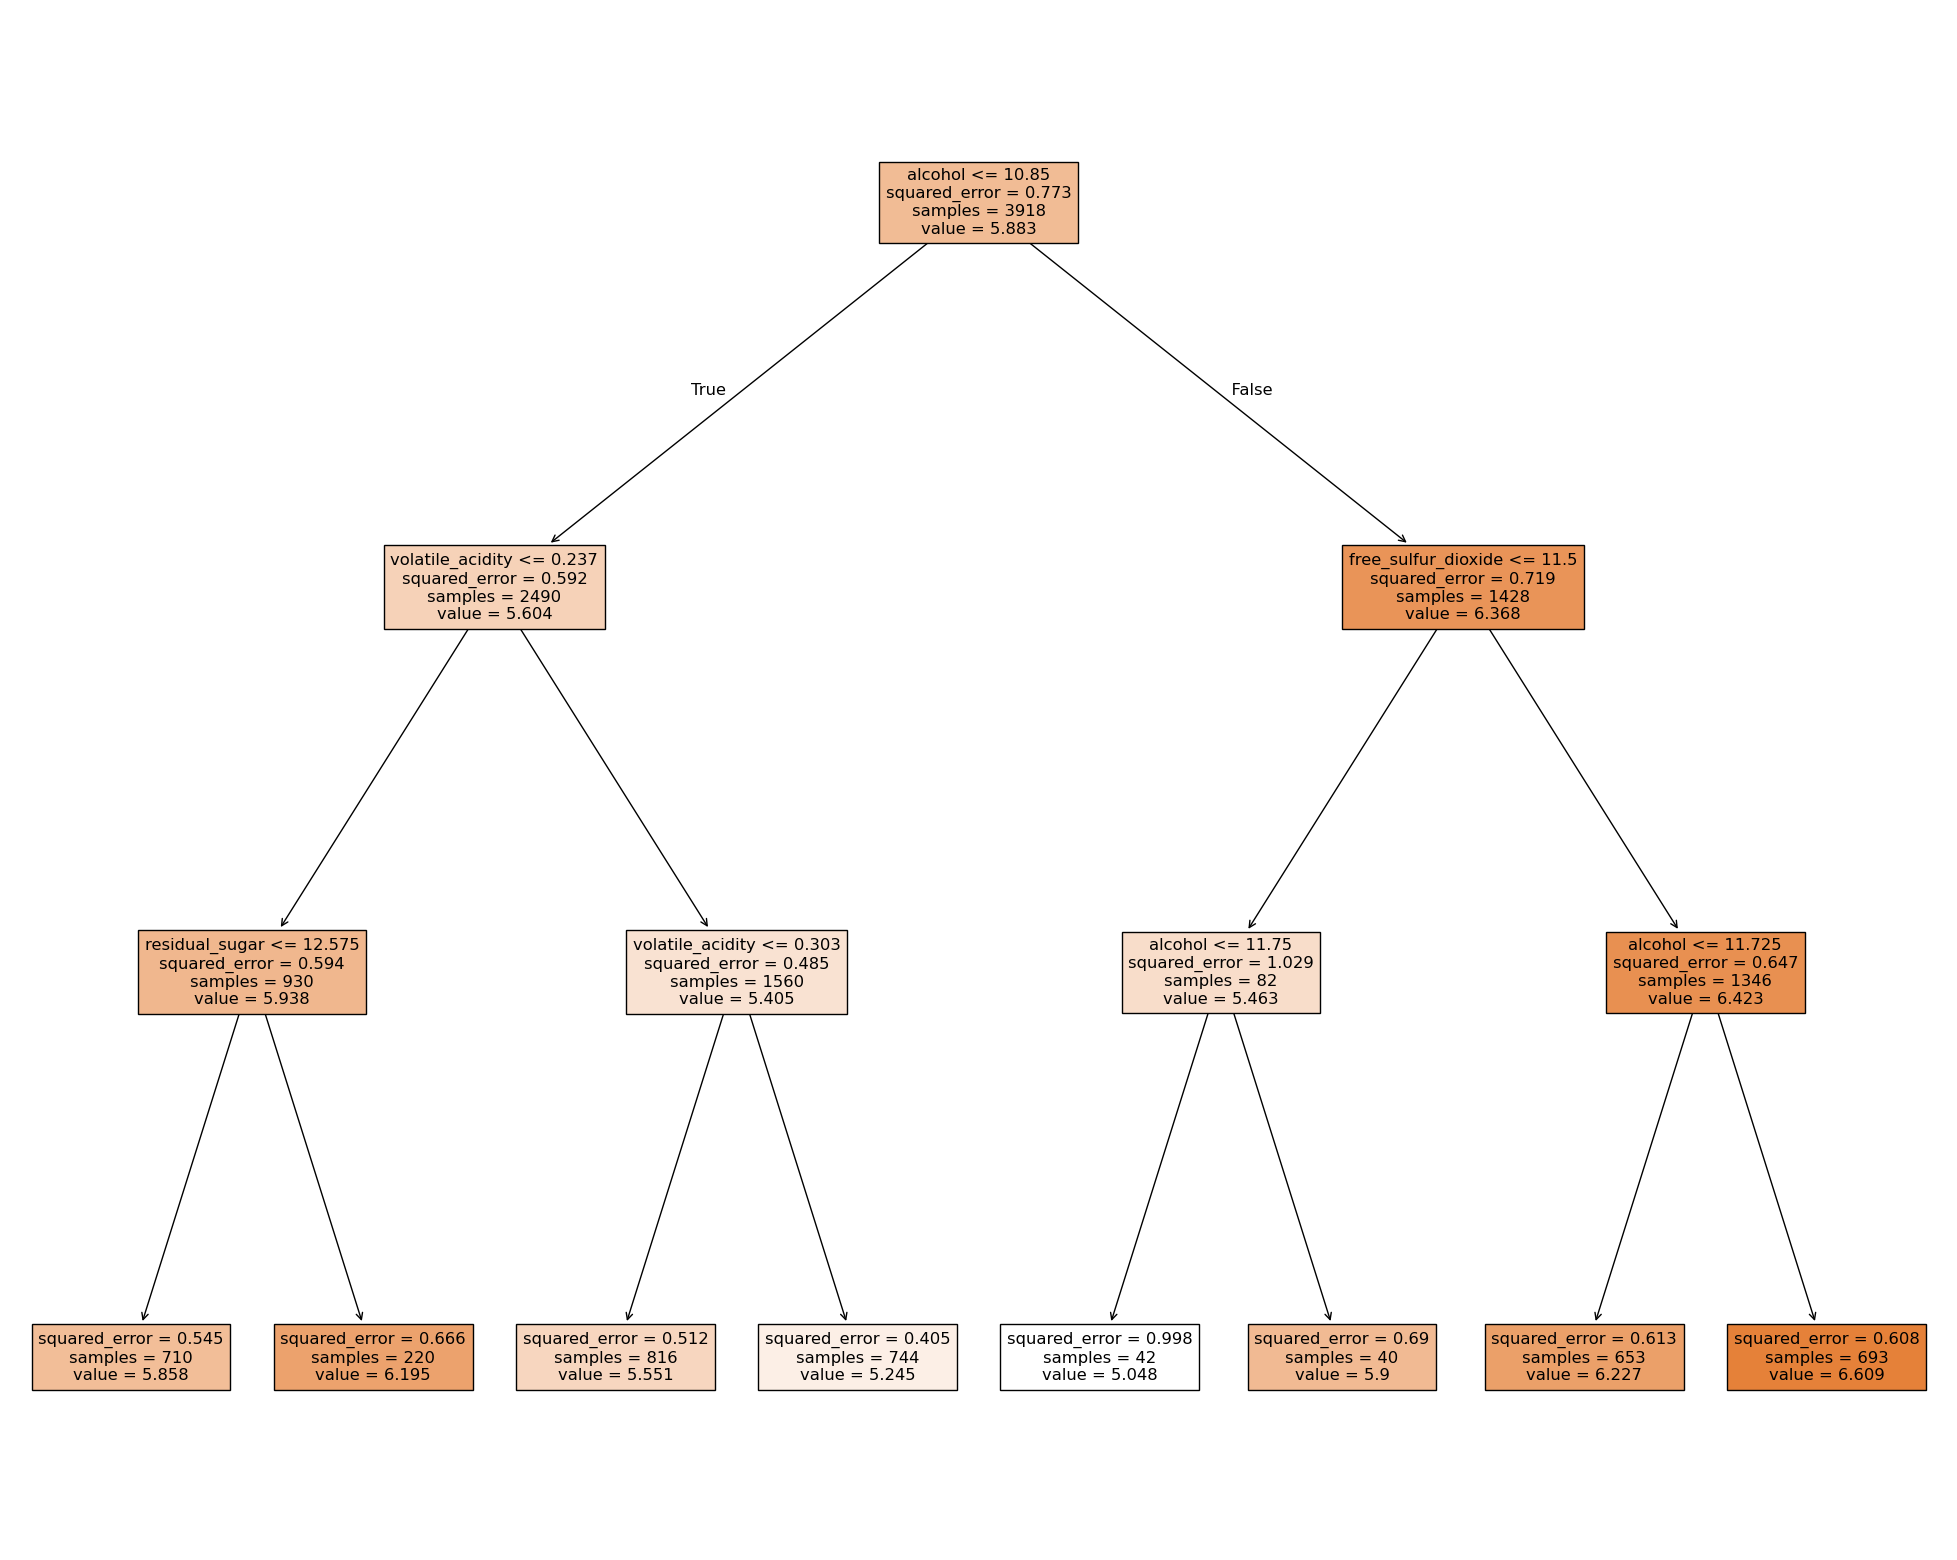

In [92]:
fig = plt.figure(figsize=(25, 20))
plot_tree(model, feature_names=df.columns[:-1], filled=True);

In [93]:
fig.savefig("depth3.svg")

### Huge tree (depth=20)

In [94]:
model = DecisionTreeRegressor(max_depth=20, random_state=666)

In [95]:
%%time
model.fit(X_train, y_train)

CPU times: user 43.2 ms, sys: 799 µs, total: 44 ms
Wall time: 41.4 ms


DecisionTreeRegressor(max_depth=20, random_state=666)

Train error

In [96]:
root_mean_squared_error(
    y_true=y_train,
    y_pred=model.predict(X_train)
)

0.1297688155546278

Test error

In [97]:
root_mean_squared_error(
    y_true=y_test,
    y_pred=model.predict(X_test)
)

0.8512843521091727

### Overfitting

Veamos cómo cambia el error de train y de test al ir variando `max_depth`

In [101]:
results = []

for depth in range(1, 21):
    model = DecisionTreeRegressor(max_depth=depth, random_state=666)
    model.fit(X_train, y_train)
    
    result = {
        "model": model,
        "depth": depth,
        "train_error": root_mean_squared_error(y_train, model.predict(X_train)),
        "test_error": root_mean_squared_error(y_test, model.predict(X_test))
    }
    
    results.append(result)

In [102]:
results_df = pd.DataFrame(results).round(3)

In [103]:
results_df

,model,depth,train_error,test_error
0,"DecisionTreeRegressor(max_depth=1, random_stat...",1,0.799,0.860
1,"DecisionTreeRegressor(max_depth=2, random_stat...",2,0.760,0.817
2,"DecisionTreeRegressor(max_depth=3, random_stat...",3,0.740,0.803
3,"DecisionTreeRegressor(max_depth=4, random_stat...",4,0.716,0.786
4,"DecisionTreeRegressor(max_depth=5, random_stat...",5,0.693,0.793
5,"DecisionTreeRegressor(max_depth=6, random_stat...",6,0.667,0.779
6,"DecisionTreeRegressor(max_depth=7, random_stat...",7,0.637,0.774
7,"DecisionTreeRegressor(max_depth=8, random_stat...",8,0.597,0.795
8,"DecisionTreeRegressor(max_depth=9, random_stat...",9,0.552,0.810
9,"DecisionTreeRegressor(max_depth=10, random_sta...",10,0.502,0.825


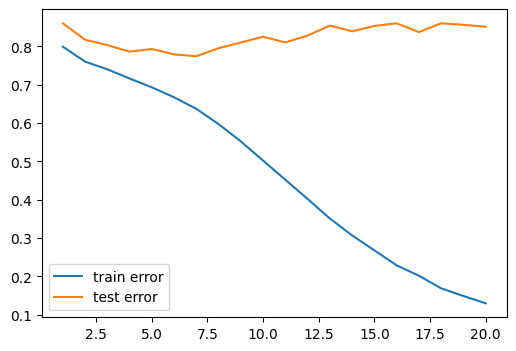

In [104]:
fig = plt.figure(figsize=(6, 4))
plt.plot(results_df.depth, results_df.train_error, label="train error")
plt.plot(results_df.depth, results_df.test_error, label="test error")
plt.legend()

Podemos ver cómo, cuando `max_depth` aumenta por encima de ~7:
 * el error de train sigue disminuyendo (más precisión en las muestras de entrenamiento)
 * el error de test aumenta (el modelo memoriza el conjunto de muestras de entrenamiento y no generaliza muy bien)

Es el famoso **overfitting**

Recuerda: el **test error** es el que hay que tener en cuenta para evaluar la performance de un modelo

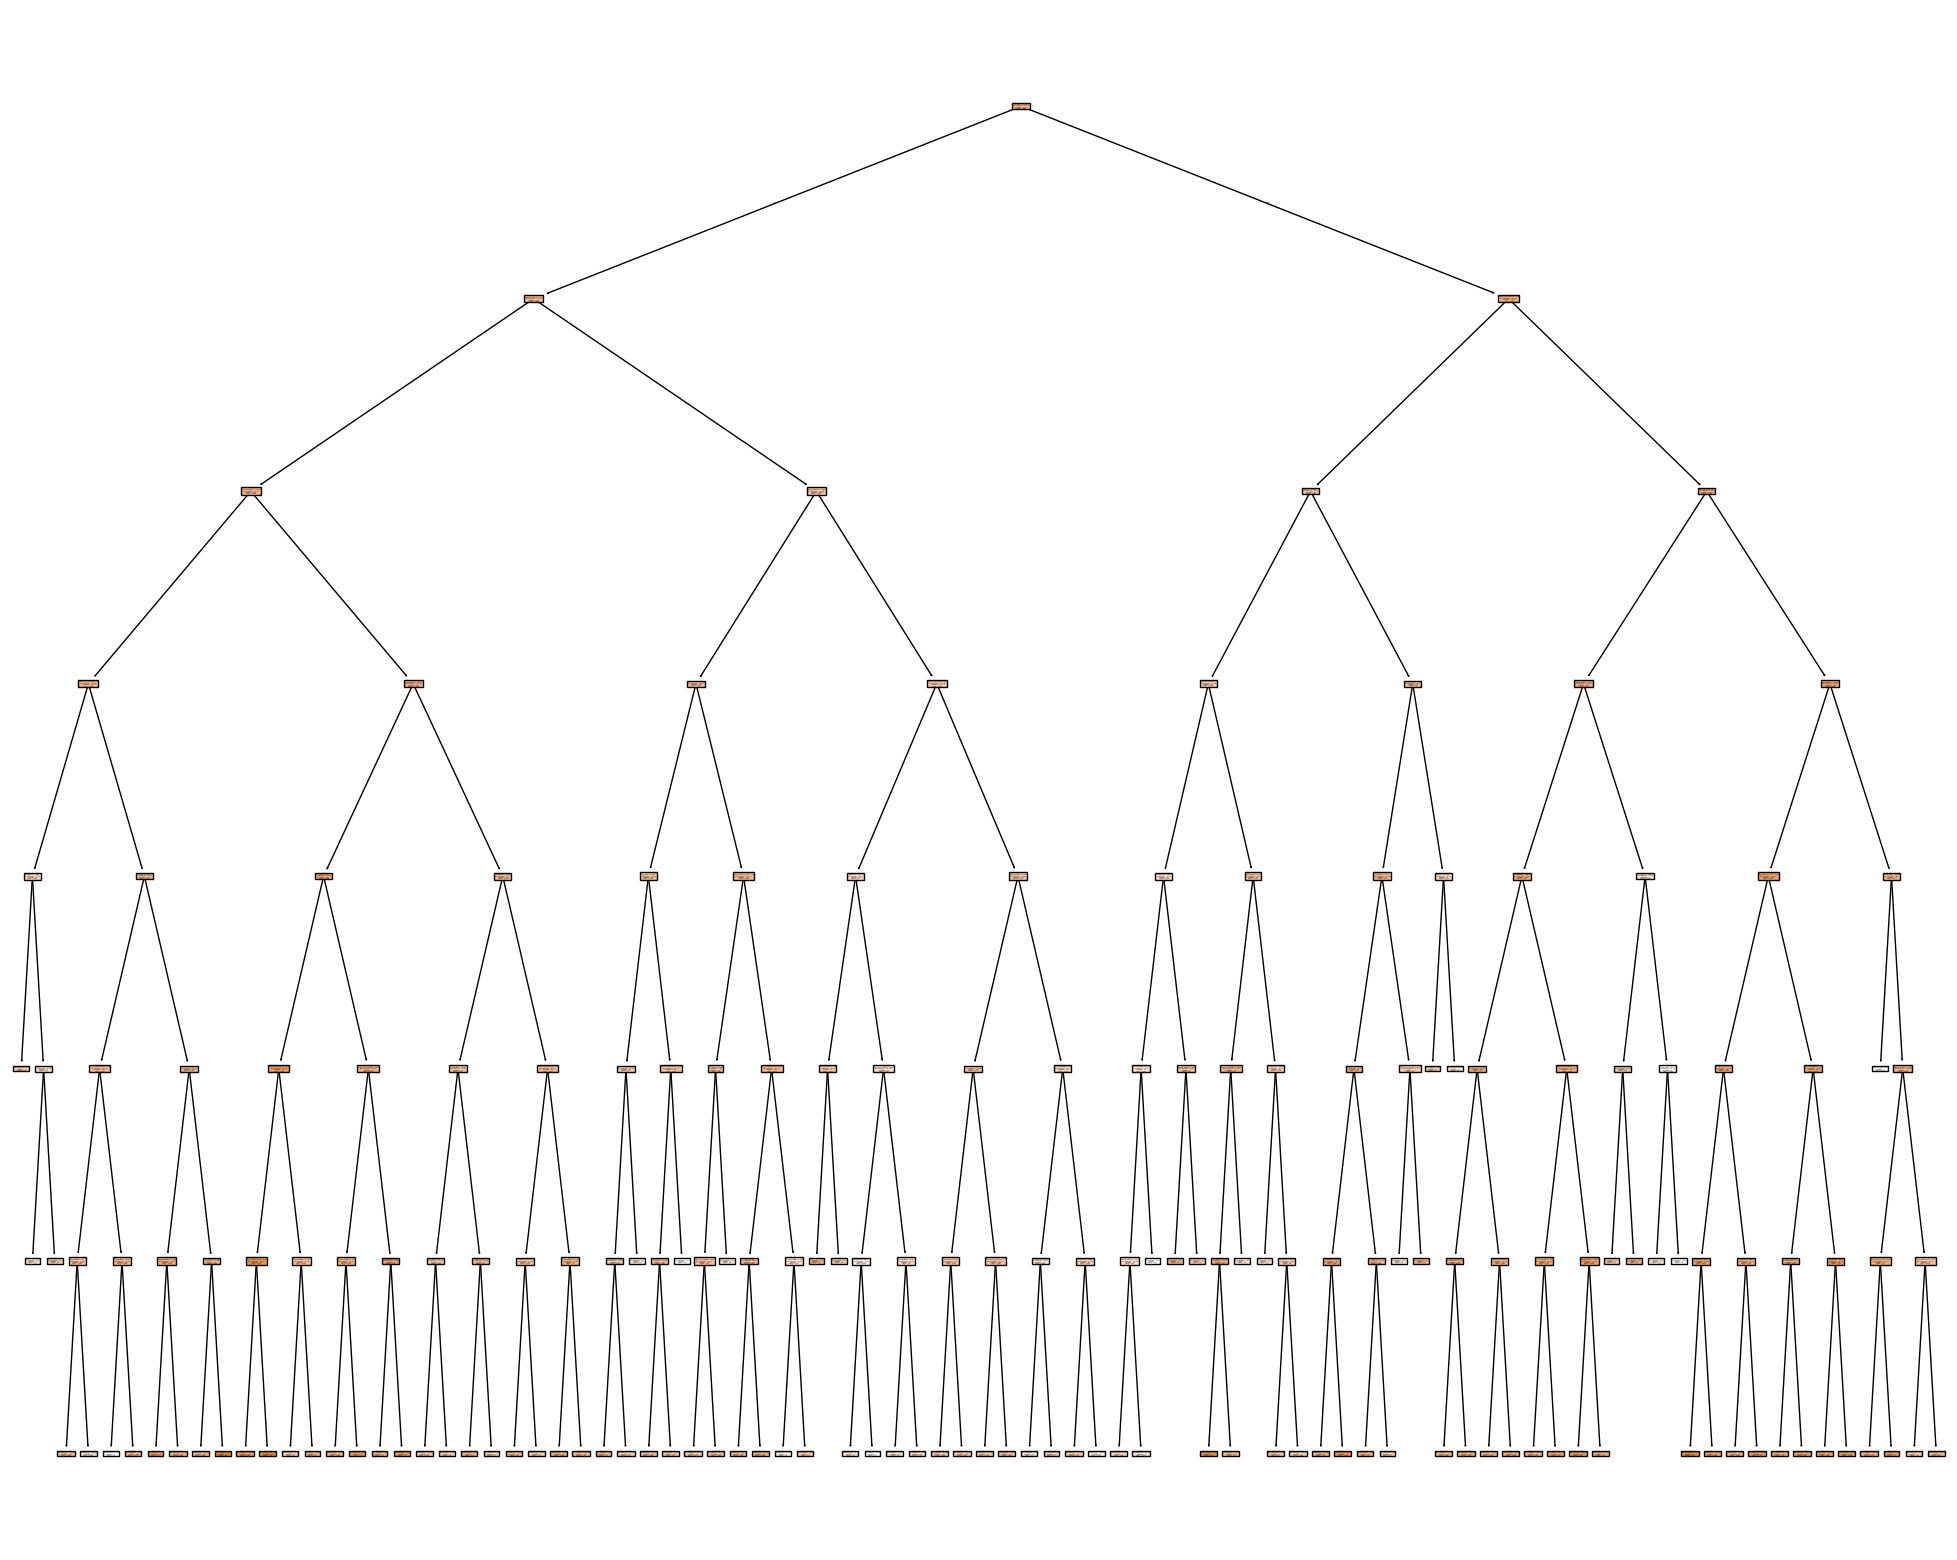

In [105]:
fig = plt.figure(figsize=(25,20))
plot_tree(results_df.loc[6].model, feature_names=df.columns[:-1], filled=True);

In [106]:
fig.savefig("depth7.svg")

### Otros hiperparámetros

Además de `max_depth`, existen otros **hiperparámetros** que nos permiten construir diferentes arquitecturas de árboles de la familia DecisionTreeRegressor:

 * `min_samples_split`: el número mínimo de muestras necesarias para dividir un nodo

 * `max_features`: el número de features a considerar cuando se busca el mejor corte

In [107]:
model = DecisionTreeRegressor(max_depth=7, min_samples_split=30, random_state=666)

In [108]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7, min_samples_split=30, random_state=666)

In [109]:
print(f"train error: {root_mean_squared_error(y_train, model.predict(X_train))}")
print(f"test error: {root_mean_squared_error(y_test, model.predict(X_test))}")

train error: 0.6522976012645689
test error: 0.7504552787765761


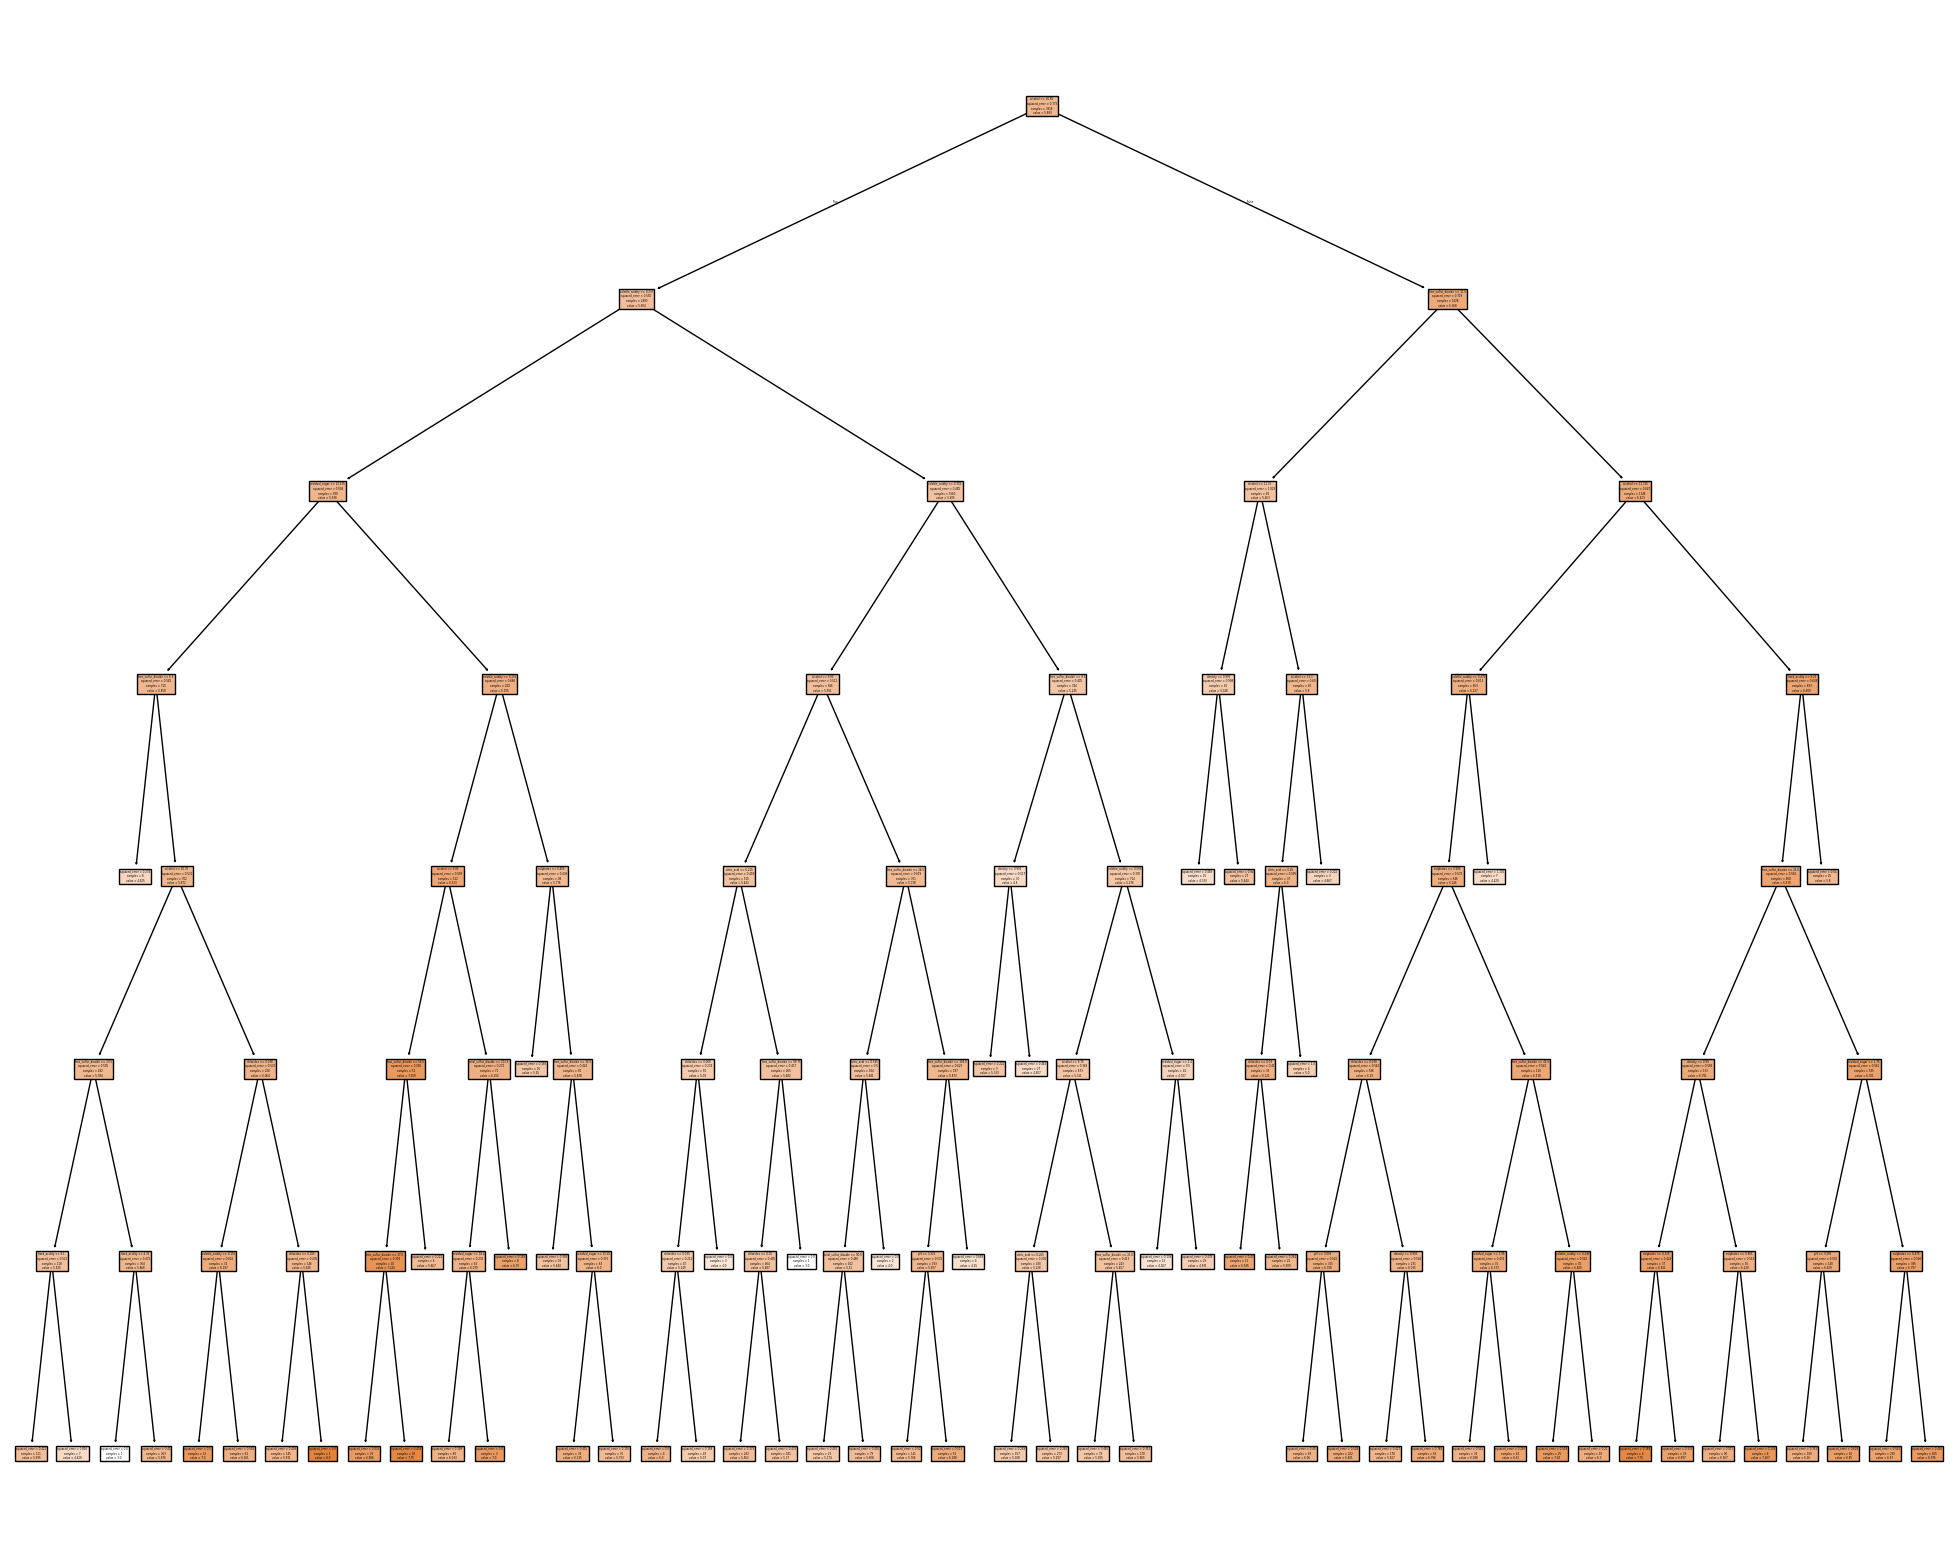

In [110]:
fig = plt.figure(figsize=(25,20))
plot_tree(model, feature_names=df.columns[:-1], filled=True);

In [111]:
fig.savefig("depth7-maxsplit30.svg")

### Grid search

Busquemos la *mejor* combinación de hiperparámetros, es decir, la que produzca el menor error de test, entre un grid prescrito de valores para cada hiperparámetro

In [112]:
from sklearn.model_selection import GridSearchCV

In [113]:
# from sklearn.model_selection import RandomizedSearchCV

In [118]:
gs = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid={
        "max_depth": [6, 7, 8],
        "min_samples_split": [20, 30, 50, 100, 200],
    },
    cv=5,
    verbose=1,
    scoring="neg_root_mean_squared_error",
    return_train_score=True
)

Probará 3 * 5 = 9 opciones

In [119]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: user 916 ms, sys: 0 ns, total: 916 ms
Wall time: 914 ms


/home/sheriff/.devpy/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 7, 8],
                         'min_samples_split': [20, 30, 50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

Ordenemos todos los árboles según su rendimiento:

In [120]:
grid_search_results = pd.DataFrame(gs.cv_results_)

grid_search_results = grid_search_results[['param_max_depth', 'param_min_samples_split',
       'mean_test_score', 'mean_train_score']]

In [121]:
grid_search_results.sort_values("mean_test_score", ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,mean_train_score
6,7,30,-0.721072,-0.649048
5,7,20,-0.723361,-0.641971
11,8,30,-0.723362,-0.625158
1,6,30,-0.724470,-0.671841
7,7,50,-0.724571,-0.658853
10,8,20,-0.725285,-0.614032
12,8,50,-0.725727,-0.640090
0,6,20,-0.726199,-0.667421
13,8,100,-0.726279,-0.664373
2,6,50,-0.726560,-0.677608


Podemos acceder al mejor estimador del Grid Search:

In [122]:
best_tree = gs.best_estimator_

In [123]:
best_tree

DecisionTreeRegressor(max_depth=7, min_samples_split=30)

## Feature importance

¿Qué importancia tiene cada feature para predecir la `quality`?

DecisionTreeRegressor tiene un atributo `feature_importances_`

In [124]:
best_tree

DecisionTreeRegressor(max_depth=7, min_samples_split=30)

In [125]:
feature_imp = pd.Series(best_tree.feature_importances_, index=df.columns[:-1]).sort_values(ascending=False)

In [126]:
feature_imp.round(3)

alcohol                 0.484
volatile_acidity        0.206
free_sulfur_dioxide     0.135
residual_sugar          0.037
fixed_acidity           0.025
chlorides               0.025
sulphates               0.025
density                 0.022
pH                      0.020
citric_acid             0.015
total_sulfur_dioxide    0.006
dtype: float64

<Axes: ylabel='None'>

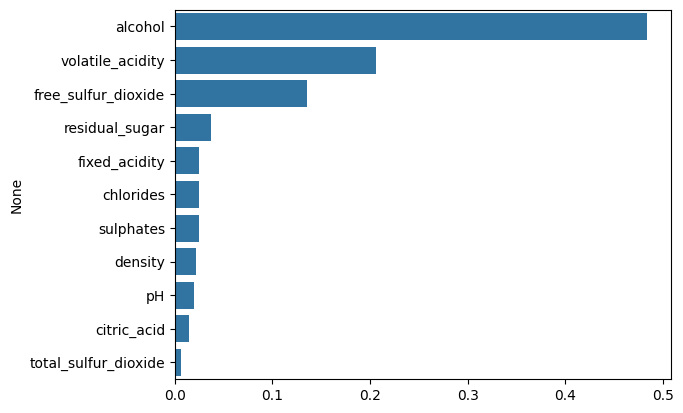

In [127]:
sns.barplot(x=feature_imp.values, y=feature_imp.index)

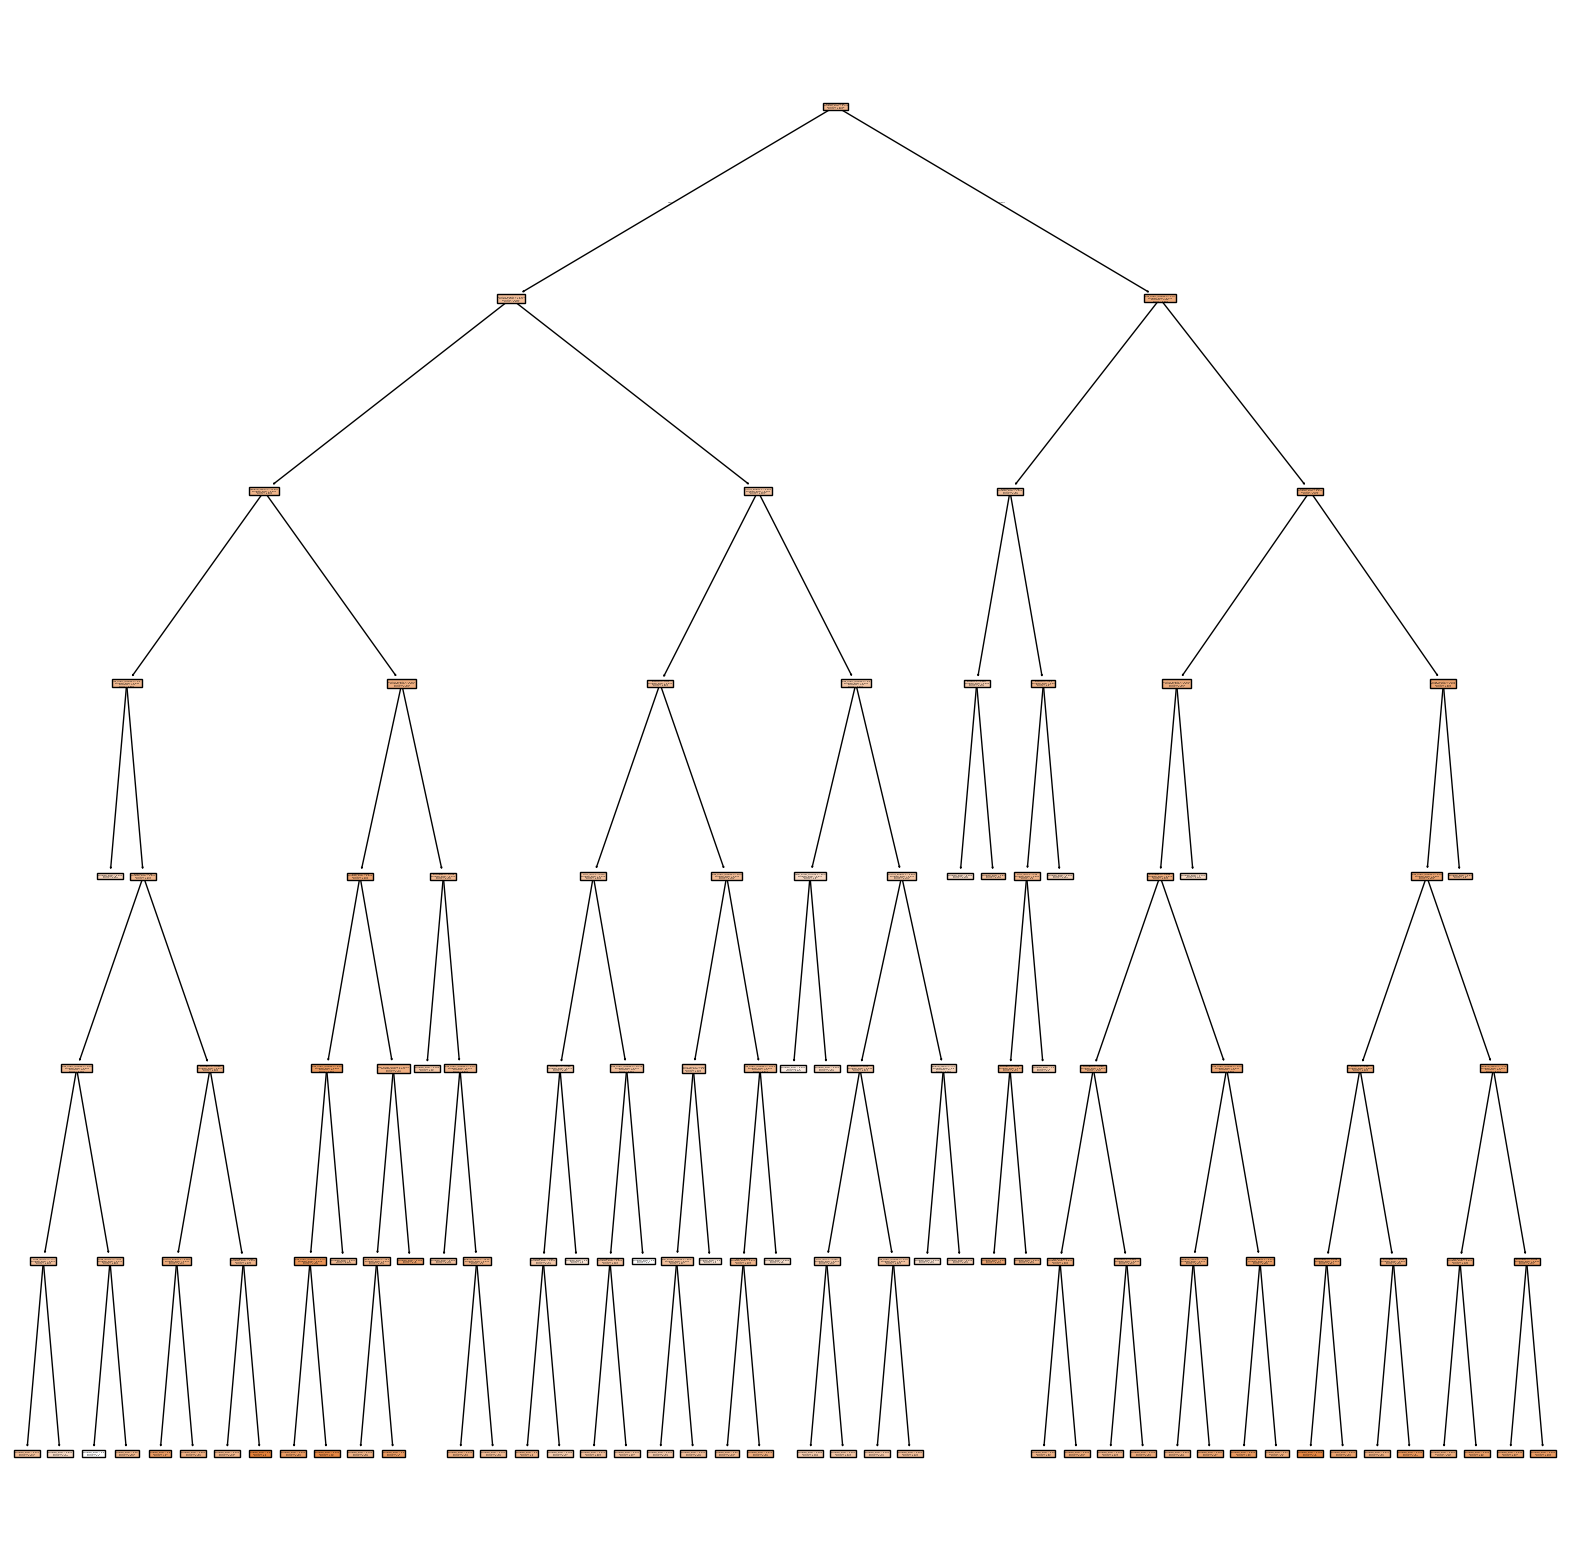

In [128]:
fig = plt.figure(figsize=(20, 20))
plot_tree(best_tree, feature_names=df.columns[:-1], filled=True);

In [ ]:
fig.savefig("decision_tree.svg", facecolor="white")

## Resumen

 * Los árboles de decisión son útiles para la regresión (`DecisionTreeRegressor`) y la clasificación (`DecisionTreeClassifier`)
 * Su comportamiento es bastante intuitivo
 * Su comportamiento es interpretable y explicable

 * Los árboles de decisión tienen overfitting cuando `max_depth` se hace muy grande (obvio, muchas hojas con muy pocas muestras _memorizadas_ cada una)
 * Prevenir el overfitting (siempre, no sólo en los métodos basados en árboles) observando el error de train y el error de test

 * Un árbol de decisión no suele ser un algoritmo de ML muy potente
 * Los árboles de decisión son los componentes básicos de algoritmos más avanzados y potentes.